## Part 1: Datasets Exploration


In this notebook, we will explore two types of data format for historic fire events in California: the fire perimeter from a GeoJSON file and satellite imagery from Google Earth.

The main purpose of exploring the datasets is to identify important features for the fire area detection. 
We will therefore examine the data and consider how to design the dataset, select the most relevant features and choose suitable data formats for training a model to detect burned areas.

The overall aim is to utilise the GeoJSON geometry as the ground truth and leverage high-resolution, multi-spectral satellite imagery as training data for our machine learning task.

#### 0. Import Libraries and Packages

In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import ee, geemap

#### 1. Load California Fire Perimeter

Our **California Fire Perimeter** dataset is provided by the California Department of Forestry and Fire Protection and covers fire events from 1950 to 2025. 

Each fire event is recorded in detail, including 
* Fire's name, 
* Year and state in which it occurred, 
* Date the alarm was raised,
* Date the fire was contained,
* Number of acres burned calculated by GIS,
* Geometry of the burned area,
* Cause of the fire and other attributes.


Data Source: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/explore?location=37.187645%2C-120.227660%2C5.95

##### 1.1 Dataset Summary

In [ ]:
# Read GeoJSON file
in_file = f"../../data/California_Historic_Fire_Perimeters.geojson"
fire_gdf = gpd.read_file(in_file)
fire_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22810 entries, 0 to 22809
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      22810 non-null  int32   
 1   YEAR_         22733 non-null  float64 
 2   STATE         22810 non-null  object  
 3   AGENCY        22761 non-null  object  
 4   UNIT_ID       22749 non-null  object  
 5   FIRE_NAME     22748 non-null  object  
 6   INC_NUM       21839 non-null  object  
 7   ALARM_DATE    17414 non-null  object  
 8   CONT_DATE     10180 non-null  object  
 9   CAUSE         22810 non-null  int32   
 10  C_METHOD      10708 non-null  float64 
 11  OBJECTIVE     22539 non-null  float64 
 12  GIS_ACRES     22810 non-null  float64 
 13  COMMENTS      2835 non-null   object  
 14  COMPLEX_NAME  611 non-null    object  
 15  IRWINID       3736 non-null   object  
 16  FIRE_NUM      17642 non-null  object  
 17  COMPLEX_ID    567 non-null    object  
 18

In [ ]:
fire_gdf.head(5)

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,1,2025.0,CA,CDF,LDF,PALISADES,00000738,"Tue, 07 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,7.0,1.0,23448.8800,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-118.51975 34.02997, -118.5198..."
1,2,2025.0,CA,CDF,LAC,EATON,00009087,"Wed, 08 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,7.0,1.0,14056.2600,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-118.10094 34.16681, -118.1009..."
2,3,2025.0,CA,CDF,ANF,HUGHES,00250270,"Wed, 22 Jan 2025 08:00:00 GMT","Tue, 28 Jan 2025 08:00:00 GMT",14,7.0,1.0,10396.8000,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-118.55862 34.58099, -118.5585..."
3,4,2025.0,CA,CCO,VNC,KENNETH,00003155,"Thu, 09 Jan 2025 08:00:00 GMT","Tue, 04 Feb 2025 08:00:00 GMT",14,2.0,1.0,998.7378,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-118.67692 34.16894, -118.6769 34.16..."
4,5,2025.0,CA,CDF,LDF,HURST,00003294,"Tue, 07 Jan 2025 08:00:00 GMT","Thu, 09 Jan 2025 08:00:00 GMT",14,7.0,1.0,831.3855,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-118.46974 34.33079, -118.46964 34.3..."


In [5]:
fire_gdf.DECADES.unique()

array(['2020-January 2025', '2010-2019', '2000-2009', '1990-1999',
       '1980-1989', '1970-1979', '1960-1969', '1950-1959', None],
      dtype=object)

After checking the dataset summary and the fist five entries, we noticed that 
* 22,810 entries are too many to process, so we need to narrow down the area of interest.
* The fire events are already divided into few decades, making it possible to focus on fires that occurred in the last five years.
* The time format of the alarm and containment dates is inconvenient for processing, e.g. extracting the year and month. Therefore, we are going to convert them into ISO formats.

In [9]:
fire_df = pd.DataFrame(fire_gdf)
fire_df["ALARM_DATE_ISO"] = pd.to_datetime(fire_df.ALARM_DATE, format='%a, %d %b %Y %H:%M:%S %Z').dt.tz_convert('UTC').dt.strftime('%Y-%m-%dT%H:%M:%SZ')
fire_df["CONT_DATE_ISO"]  = pd.to_datetime(fire_df.CONT_DATE, format='%a, %d %b %Y %H:%M:%S %Z').dt.tz_convert('UTC').dt.strftime('%Y-%m-%dT%H:%M:%SZ')

In [7]:
fire_df.head(5)

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry,ALARM_DATE_ISO,CONT_DATE_ISO
0,1,2025.0,CA,CDF,LDF,PALISADES,00000738,"Tue, 07 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,...,23448.8800,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-118.51975 34.02997, -118.5198...",2025-01-07T08:00:00Z,2025-01-31T08:00:00Z
1,2,2025.0,CA,CDF,LAC,EATON,00009087,"Wed, 08 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,...,14056.2600,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-118.10094 34.16681, -118.1009...",2025-01-08T08:00:00Z,2025-01-31T08:00:00Z
2,3,2025.0,CA,CDF,ANF,HUGHES,00250270,"Wed, 22 Jan 2025 08:00:00 GMT","Tue, 28 Jan 2025 08:00:00 GMT",14,...,10396.8000,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-118.55862 34.58099, -118.5585...",2025-01-22T08:00:00Z,2025-01-28T08:00:00Z
3,4,2025.0,CA,CCO,VNC,KENNETH,00003155,"Thu, 09 Jan 2025 08:00:00 GMT","Tue, 04 Feb 2025 08:00:00 GMT",14,...,998.7378,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-118.67692 34.16894, -118.6769 34.16...",2025-01-09T08:00:00Z,2025-02-04T08:00:00Z
4,5,2025.0,CA,CDF,LDF,HURST,00003294,"Tue, 07 Jan 2025 08:00:00 GMT","Thu, 09 Jan 2025 08:00:00 GMT",14,...,831.3855,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-118.46974 34.33079, -118.46964 34.3...",2025-01-07T08:00:00Z,2025-01-09T08:00:00Z


##### 1.2 Analysis of Fire Events in The Last Five Years

We focused on fire events in the last five years and visualised the distribution of fire areas. It's worth noting that the scale of fire events are varies and this visualisation showed us that the size of satellite images depends on how many acres were burned in the fire events. From this perspective, we need to strike a balance between image size and the amount of training data we can create from this metadata to generate an appropiate dataset for our model.

In [6]:
aoi = fire_gdf[fire_gdf.DECADES == "2020-January 2025"]

In [7]:
aoi = gpd.GeoDataFrame(aoi)

<Axes: >

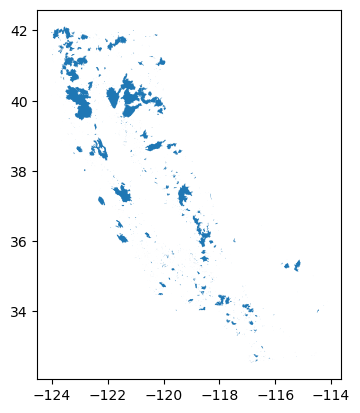

In [11]:
aoi.geometry.plot()   ## 2020-2025

#### Analysis Based on The Sacle of Fire Events

We've chosen 100, 1000 and 10000 as the thresholds for magnifying the fire events.

In order to generate an image sized 224 * 224 pixels from satellite imagery with a resolution of 10 metres, we need to capture at least 100 acres of events. 
Thus we adopt fire events covering between 100 and 10,000 acres to acquire the corresponding satellite imagery.

In [ ]:
major_fires = fire_df[
    (fire_df.GIS_ACRES > 10000) &
    (fire_df.DECADES == "2020-January 2025") &
    (fire_df.ALARM_DATE_ISO.notna()) &
    (fire_df.CONT_DATE_ISO.notna()) 
    ]

In [14]:
print(f"Fire events with over 10,000 acres are {len(major_fires)}")

Fire events with over 10,000 acres are 81


In [11]:
medium_fires = fire_df[
    (fire_df.GIS_ACRES < 10000) & 
    (fire_df.GIS_ACRES > 1000) & 
    (fire_df.DECADES == "2020-January 2025") &
    (fire_df.ALARM_DATE_ISO.notna()) &
    (fire_df.CONT_DATE_ISO.notna()) ]

In [16]:
print(f"The number of fire events with 1,000 ~ 10,000 acres: {len(medium_fires)}")

The number of fire events with 1,000 ~ 10,000 acres: 133


In [12]:
small_fires = fire_df[
    (fire_df.GIS_ACRES < 1000) & 
    (fire_df.GIS_ACRES > 100) & 
    (fire_df.DECADES == "2020-January 2025") &
    (fire_df.ALARM_DATE_ISO.notna()) &
    (fire_df.CONT_DATE_ISO.notna()) ]

In [17]:
print(f"The number of fire events with 100 ~ 1,000 acres: {len(small_fires)}")

The number of fire events with 100 ~ 1,000 acres: 361


In [13]:
very_small_fires = fire_df[
    (fire_df.GIS_ACRES < 100) & 
    (fire_df.GIS_ACRES > 0) & 
    (fire_df.DECADES == "2020-January 2025") &
    (fire_df.ALARM_DATE_ISO.notna()) &
    (fire_df.CONT_DATE_ISO.notna()) ]

In [18]:
print(f"The number of fire events with less than 100 acres: {len(very_small_fires)}")

The number of fire events with less than 100 acres: 1447


#### 2. Copernicus Sentinel-2

Copernicus Sentinel-2 (COPERNICUS/S2_SR_HARMONIZED) data involves using the surface reflectance information in the data to calculate spectral indices like the Normalized Burn Ratio (NBR), or employing machine learning algorithms with spectral and textural features to distinguish burned areas from other land cover changes.


In order to access Google Earth, we need to create a Google Cloud account and register a cloud project for commercial or non-commercial purposes. In our case, we can register for non-commercial use by answering questions about the projects (e.g., organisation, academic institution, research question and geographic scope).


We then need to authenticate and initialise the project by runing the following code.


tutorials: https://www.un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/burn-severity-earth-engine

In [35]:
ee.Authenticate()
ee.Initialize()

In [ ]:
# Create a region list and collect the critical attributs to analyse
analysis_regions = []
for idx, fire in small_fires.iterrows():
    fire_geom = fire.geometry
    analysis_regions.append({
        'name': fire.FIRE_NAME,
        'geometry': fire_geom,
        'alarm_date': fire.ALARM_DATE_ISO,
        'containment_date': fire.CONT_DATE_ISO,
        'acres_burned': fire.GIS_ACRES
    })

In [37]:
region = analysis_regions[0]
region

{'name': 'KENNETH',
 'geometry': <POLYGON ((-118.677 34.169, -118.677 34.169, -118.677 34.169, -118.677 34.16...>,
 'alarm_date': '2025-01-09T08:00:00Z',
 'containment_date': '2025-02-04T08:00:00Z',
 'acres_burned': 998.7378}

In [ ]:
# Convert GeoDataFrame to Googel Earth Geometry object
region_gdf = gpd.GeoDataFrame([region], geometry='geometry', crs='EPSG:4326')
region_ee = geemap.geopandas_to_ee(region_gdf)
region_geom = region_ee.geometry()
print(f"Processing region: {region['name']}")

Processing region: KENNETH


In [ ]:
# Check the coordniates of the region bounds
bounds = region_geom.bounds()
coord = bounds.coordinates().getInfo()[0]
coord

[[-118.70228197179703, 34.161008712197976],
 [-118.669481673538, 34.161008712197976],
 [-118.669481673538, 34.18776087259832],
 [-118.70228197179703, 34.18776087259832],
 [-118.70228197179703, 34.161008712197976]]

In [ ]:
# Parameters for data acquisition
TARGET_PIXELS = 224
SCALE = 20  # Meters per pixel
# Approximate meters per degree at equator
# We prefer to large image for cropping
METERS_PER_DEGREE = 111320 

In [41]:
def expand_region(region_geom):
    """Expand region bounds if smaller than target crop size in meters."""
    # Extract the coordinates and bounds
    bounds = region_geom.bounds()
    coord = bounds.coordinates().getInfo()[0]
    xmin, ymin = coord[0]
    xmax, ymax = coord[2]

    # Compute the image size
    width_m = (xmax - xmin) * METERS_PER_DEGREE
    height_m = (ymax - ymin) * METERS_PER_DEGREE
    min_size_m = SCALE * TARGET_PIXELS

    # Compute padding if the export image will smaller than target
    pad_x = max(0, (min_size_m - width_m) / METERS_PER_DEGREE / 2)
    pad_y = max(0, (min_size_m - height_m) / METERS_PER_DEGREE / 2)

    # Expand the bounds
    new_bounds = ee.Geometry.Rectangle([xmin - pad_x, ymin - pad_y, xmax + pad_x, ymax + pad_y])
    return new_bounds

In [44]:
# Expand fire event regions, making sure the exported images are larger than 224 * 224
expand_regions = expand_region(region_geom=region_geom)

In [45]:
# Parameters for data acquisition
CLOUD_THRESHOLD = 20
PRE_FIRE_DAYS = 60  # Days before fire to include
POST_FIRE_DAYS = 30  # Days after containment to include

In [43]:
# Calculate time window for imagery using ISO
pre_fire_start = ee.Date(region['alarm_date']).advance(-PRE_FIRE_DAYS, 'day')
post_fire_end = ee.Date(region['containment_date']).advance(POST_FIRE_DAYS, 'day')

In [47]:
# Get Sentinel-2 collection for this region and time period
collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(expand_regions)
    .filterDate(pre_fire_start, post_fire_end)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_THRESHOLD))
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])
)

In [48]:
# Create pre-/post-fire composites and fire mask
pre_fire_img = collection.filterDate(pre_fire_start, ee.Date(region['alarm_date'])).median().clip(expand_regions)
post_fire_img = collection.filterDate(ee.Date(region['containment_date']), post_fire_end).median().clip(expand_regions)
fire_mask = ee.Image(0).byte().paint(region_geom, 1).rename("mask").clip(expand_regions)

# Calculate NBR
pre_fire_nbr = pre_fire_img.normalizedDifference(['B8', 'B12']).rename('NBR')
post_fire_nbr = post_fire_img.normalizedDifference(['B8', 'B12']).rename('NBR')
dnbr = pre_fire_nbr.subtract(post_fire_nbr).rename('dNBR')

In [ ]:
# Combine all bands into separate images for smaller exports
clean_name = region['name'].replace(' ', '_').replace('/', '_')
alarm_date_short = region['alarm_date'][:10].replace('-', '')

pre_fire_visual = pre_fire_img.select(['B2', 'B3', 'B4', 'B8', 'B12'])  
post_fire_visual = post_fire_img.select(['B2', 'B3', 'B4', 'B8', 'B12'])  

In [ ]:
# Create an interactive map
Map = geemap.Map()
Map.add_basemap('SATELLITE')  # Add satellite basemap

# Pre-fire 
pre_fire_rgb = pre_fire_img.select(['B4', 'B3', 'B2'])  # RGB bands
Map.addLayer(pre_fire_rgb, {'min': 0, 'max': 3000}, 'Pre-fire RGB')

# Post-fire
post_fire_rgb = post_fire_img.select(['B4', 'B3', 'B2'])  # RGB bands
Map.addLayer(post_fire_rgb, {'min': 0, 'max': 3000}, 'Post-fire RGB')

# Pre-fire false color (for vegetation)
pre_fire_false_color = pre_fire_img.select(['B8', 'B4', 'B3'])  # NIR, Red, Green
Map.addLayer(pre_fire_false_color, {'min': 0, 'max': 3000}, 'Pre-fire False Color')

# Post-fire false color
post_fire_false_color = post_fire_img.select(['B8', 'B4', 'B3'])  # NIR, Red, Green
Map.addLayer(post_fire_false_color, {'min': 0, 'max': 3000}, 'Post-fire False Color')

# NBR difference (dNBR) for fire severity
dnbr_vis = {
    'min': -1, 
    'max': 1,
    'palette': ['blue', 'green', 'yellow', 'red']  # Blue (unburned) to Red (severely burned)
}
Map.addLayer(dnbr, dnbr_vis, 'dNBR Fire Severity')

# Fire mask
fire_mask_vis = {
    'min': 0,
    'max': 1,
    'palette': ['00000000', 'FFFFFF']  # Transparent, White
}
Map.addLayer(fire_mask, fire_mask_vis, 'Fire Mask')
Map.centerObject(expand_regions, 10)
Map


Map(center=[34.17438483513894, -118.68588182266683], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
### ==============================================================================================
### Export image to Googel Drive
### ==============================================================================================
output_folder = f"test"

# Export Pre-fire image 
task1 = ee.batch.Export.image.toDrive(
        image=pre_fire_visual,
        description=f'{clean_name}_{alarm_date_short}',
        folder=f'{output_folder}/pre_fire',
        scale=20,
        region=expand_regions,
        maxPixels=1e10,
        fileFormat='GeoTIFF'
    )
task1.start()

# Export Post-fire image 
task2 = ee.batch.Export.image.toDrive(
    image=post_fire_visual,
    description=f'{clean_name}_{alarm_date_short}',
    folder=f'{output_folder}/post_fire',
    scale=20,
    region=expand_regions,
    maxPixels=1e10,
    fileFormat='GeoTIFF'
)
task2.start()

# Export Fire mask
task3 = ee.batch.Export.image.toDrive(
    image=fire_mask,
    description=f'{clean_name}_{alarm_date_short}',
    folder=f'{output_folder}/masks',
    scale=20,
    region=expand_regions,
    maxPixels=1e10,
    fileFormat='GeoTIFF'
)
task3.start()

# Export dNBR
task4 = ee.batch.Export.image.toDrive(
    image=dnbr,
    description=f'{clean_name}_{alarm_date_short}',
    folder=f'{output_folder}/dnbr',
    scale=20,
    region=expand_regions,
    maxPixels=1e10,
    fileFormat='GeoTIFF'
)
task4.start()